## Package imports

In [1]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from matplotlib import pyplot as plt
import numpy as np

import pickle

Using TensorFlow backend.


## Parameters

In [2]:
batch_size = 1024
num_classes = 2
epochs = 20

## Data

In [3]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

x = data['x']
y = data['y']
xb = data['xb']
yb = data['yb']

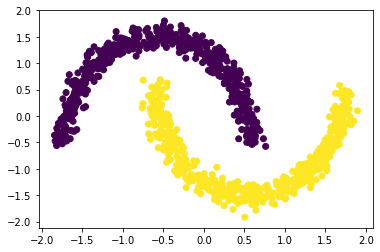

In [4]:
plt.scatter(x.T[0], x.T[1], c=y);

Now we find a reasonable set of parameters for DBSCAN to get border points.

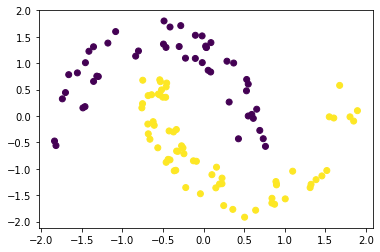

In [5]:
#cluster = DBSCAN(eps=0.07, min_samples=4)
#cluster.fit(x)
#xb = x[np.where(cluster.labels_ == -1)[0]]
#yb = y[np.where(cluster.labels_ == -1)[0]]
#print(len(xb))
plt.scatter(xb.T[0], xb.T[1], c=yb);

## Model

$$
\begin{align}
n_0 &= 2 \\
N &= 3
\end{align}
$$

For 1 hidden layer with 2 neurons,

$$
\begin{align}
n_1 &= 2 \\
n_L &= 2 \\
L &= 1
\end{align}
$$

And therefore $\prod\limits_{i=1}^{L-1} \lfloor \frac{n_i}{n_0} \rfloor^{n_0} = 1$, $\sum\limits_{j=0}^{n_0} {n_L \choose j} = 4$

In [6]:
def get_model(bn_dropout=False):
    if bn_dropout:
        return Sequential([
            Dense(2, input_shape=(2,)),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),
            
            Dense(2),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
    else:
        return Sequential([
            Dense(2, activation='relu', input_shape=(2,)),
            Dense(2, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

# Experiments

We want to run experiments with combinations of the following settings:

* BatchNorm - ReLU - Dropout used or not (2)
* LipschitzLR used or not (2)
* Full data, reduced data, or reduced data with oversampling (3)

For each of the 12 experiments, we split 70-30.

## LipschitzLR definitions

In [1]:
batch_size = 128
num_classes = 2

In [2]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """

    Kz = 0.
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    
        activ = np.linalg.norm(func([xb]))
        if activ > Kz:
            Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
    lr = 1 / K_
    print('Epoch', epoch + 1, 'LR =', lr)
    return lr

In [8]:
def run_one_experiment(bn_dropout=False, lipschitz_lr=False, reduce_data=False, oversample=False):
    # Step 1: Get the model
    model = get_model(bn_dropout=bn_dropout)
    
    # Step 2: Get the data
    if reduce_data:
        x_train, x_test, y_train, y_test = train_test_split(xb, yb)
        
        if oversample:
            x_train = np.concatenate([x_train, x_train, x_train], axis=0)
            y_train = np.concatenate([y_train, y_train, y_train], axis=0)
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
    ####################
    # LipschitzLR code #
    ####################
    
    def lr_schedule(epoch):
        """Learning Rate Schedule
        # Arguments
            epoch (int): The number of epochs
        # Returns
            lr (float32): learning rate
        """

        Kz = 0.
        for i in range((len(x_train) - 1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i:end_i]

            activ = np.linalg.norm(func([xb]))
            if activ > Kz:
                Kz = activ

        K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
        lr = 1 / K_
        print('Epoch', epoch + 1, 'LR =', lr)
        return lr
    
    ####################
    
    
    # Step 3: Train the model
    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    if lipschitz_lr:
        func = K.function([model.layers[0].input], [model.layers[-2].output])
        lr_scheduler = LearningRateScheduler(lr_schedule)
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test), epochs=100, callbacks=[lr_scheduler])
    else:
        model.fit(x_train, y_train, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test), epochs=100)
    
    print('\nTrain accuracy:', model.history.history['acc'][-1], 
          '\nValidation accuracy:', model.history.history['val_acc'][-1])
    print('-' * 100)
    
    acc.append(model.history.history['acc'][-1])
    val_acc.append(model.history.history['val_acc'][-1])

In [9]:
acc = []
val_acc = []

In [10]:
def run_20_experiments(**kwargs):
    global acc, val_acc
    
    acc = []
    val_acc = []
    
    count = 0
    while count != 20:
        try:
            print('Trying run', count + 1)
            run_one_experiment(**kwargs)
            count += 1
        except:
            pass
    
    print(acc, '\n', val_acc)

## Experiment \#1 (000): NN with no BatchNorm/Dropout, full data, standard LR

In [11]:
run_20_experiments()

W1015 23:30:30.299593 140555754833536 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 23:30:30.341519 140555754833536 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 23:30:30.347760 140555754833536 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Trying run 1


W1015 23:30:30.502512 140555754833536 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1015 23:30:30.572823 140555754833536 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1015 23:30:30.595839 140555754833536 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1015 23:30:31.374029 140555754833536 deprecation_wrapper.py:119] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is depreca


Train accuracy: 0.5759999752044678 
Validation accuracy: 0.5720000267028809
----------------------------------------------------------------------------------------------------
Trying run 2

Train accuracy: 0.8053333163261414 
Validation accuracy: 0.7919999957084656
----------------------------------------------------------------------------------------------------
Trying run 3

Train accuracy: 0.5026666522026062 
Validation accuracy: 0.492000013589859
----------------------------------------------------------------------------------------------------
Trying run 4

Train accuracy: 0.8453333377838135 
Validation accuracy: 0.8119999766349792
----------------------------------------------------------------------------------------------------
Trying run 5

Train accuracy: 0.7506666779518127 
Validation accuracy: 0.7160000205039978
----------------------------------------------------------------------------------------------------
Trying run 6

Train accuracy: 0.8133333325386047 
Validatio

## Experiment \#2 (100): BatchNorm/Dropout, full data, standard LR

In [12]:
run_20_experiments(bn_dropout=True)

Trying run 1


W1015 23:31:31.034137 140555754833536 deprecation.py:506] From /usr/local/lib64/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Train accuracy: 0.30266666412353516 
Validation accuracy: 0.1720000058412552
----------------------------------------------------------------------------------------------------
Trying run 2

Train accuracy: 0.3853333294391632 
Validation accuracy: 0.4000000059604645
----------------------------------------------------------------------------------------------------
Trying run 3

Train accuracy: 0.6786666512489319 
Validation accuracy: 0.7480000257492065
----------------------------------------------------------------------------------------------------
Trying run 4

Train accuracy: 0.4546666741371155 
Validation accuracy: 0.3720000088214874
----------------------------------------------------------------------------------------------------
Trying run 5

Train accuracy: 0.7746666669845581 
Validation accuracy: 0.7960000038146973
----------------------------------------------------------------------------------------------------
Trying run 6

Train accuracy: 0.7106666564941406 
Validat

## Experiment \#3 (001): No BN/Dropout, full data, LipschitzLR

In [13]:
run_20_experiments(lipschitz_lr=True)

Trying run 1
Epoch 1 LR = 114.58704744041268
Epoch 2 LR = 0.016645138292421802
Epoch 3 LR = 0.016645138292421802
Epoch 4 LR = 0.016645138292421802
Epoch 5 LR = 0.016645138292421802
Epoch 6 LR = 0.016645138292421802
Epoch 7 LR = 0.016645138292421802
Epoch 8 LR = 0.016645138292421802
Epoch 9 LR = 0.016645138292421802
Epoch 10 LR = 0.016645138292421802
Epoch 11 LR = 0.016645138292421802
Epoch 12 LR = 0.016645138292421802
Epoch 13 LR = 0.016645138292421802
Epoch 14 LR = 0.016645138292421802
Epoch 15 LR = 0.016645138292421802
Epoch 16 LR = 0.016645138292421802
Epoch 17 LR = 0.016645138292421802
Epoch 18 LR = 0.016645138292421802
Epoch 19 LR = 0.016645138292421802
Epoch 20 LR = 0.016645138292421802
Epoch 21 LR = 0.016645138292421802
Epoch 22 LR = 0.016645138292421802
Epoch 23 LR = 0.016645138292421802
Epoch 24 LR = 0.016645138292421802
Epoch 25 LR = 0.016645138292421802
Epoch 26 LR = 0.016645138292421802
Epoch 27 LR = 0.016645138292421802
Epoch 28 LR = 0.016645138292421802
Epoch 29 LR = 0.01

Epoch 39 LR = 4.116565490844183
Epoch 40 LR = 4.189404491447252
Epoch 41 LR = 4.124497143625215
Epoch 42 LR = 4.196908968935657
Epoch 43 LR = 4.133845221804478
Epoch 44 LR = 4.204046088551577
Epoch 45 LR = 4.143609015499867
Epoch 46 LR = 4.2109850276272525
Epoch 47 LR = 4.153485105935778
Epoch 48 LR = 4.217769030781625
Epoch 49 LR = 4.1633921146090636
Epoch 50 LR = 4.224409518458892
Epoch 51 LR = 4.173308346540328
Epoch 52 LR = 4.230906097512846
Epoch 53 LR = 4.183217949531498
Epoch 54 LR = 4.2372621582469625
Epoch 55 LR = 4.193118395773595
Epoch 56 LR = 4.243475001361084
Epoch 57 LR = 4.202999217318278
Epoch 58 LR = 4.249549740203802
Epoch 59 LR = 4.21285292813929
Epoch 60 LR = 4.25549617319091
Epoch 61 LR = 4.222662876042643
Epoch 62 LR = 4.261323161016799
Epoch 63 LR = 4.2324638944725645
Epoch 64 LR = 4.267008219613933
Epoch 65 LR = 4.2421093912574275
Epoch 66 LR = 4.272673375045077
Epoch 67 LR = 4.251642716586566
Epoch 68 LR = 4.278236038950649
Epoch 69 LR = 4.261081268786204
Epoch

Epoch 74 LR = 0.21428291898598087
Epoch 75 LR = 0.21428291898598087
Epoch 76 LR = 0.21428291898598087
Epoch 77 LR = 0.21428291898598087
Epoch 78 LR = 0.21428291898598087
Epoch 79 LR = 0.21428291898598087
Epoch 80 LR = 0.21428291898598087
Epoch 81 LR = 0.21428291898598087
Epoch 82 LR = 0.21428291898598087
Epoch 83 LR = 0.21428291898598087
Epoch 84 LR = 0.21428291898598087
Epoch 85 LR = 0.21428291898598087
Epoch 86 LR = 0.21428291898598087
Epoch 87 LR = 0.21428291898598087
Epoch 88 LR = 0.21428291898598087
Epoch 89 LR = 0.21428291898598087
Epoch 90 LR = 0.21428291898598087
Epoch 91 LR = 0.21428291898598087
Epoch 92 LR = 0.21428291898598087
Epoch 93 LR = 0.21428291898598087
Epoch 94 LR = 0.21428291898598087
Epoch 95 LR = 0.21428291898598087
Epoch 96 LR = 0.21428291898598087
Epoch 97 LR = 0.21428291898598087
Epoch 98 LR = 0.21428291898598087
Epoch 99 LR = 0.21428291898598087
Epoch 100 LR = 0.21428291898598087

Train accuracy: 0.4906666576862335 
Validation accuracy: 0.527999997138977
-----


Train accuracy: 0.4893333315849304 
Validation accuracy: 0.5320000052452087
----------------------------------------------------------------------------------------------------
Trying run 8
Epoch 1 LR = 267.3808224796333
Trying run 8
Epoch 1 LR = 76.52405899100219
Epoch 2 LR = 229.5246327497752
Trying run 8
Epoch 1 LR = 74.30861142843658
Trying run 8
Epoch 1 LR = 82.95596860667291
Epoch 2 LR = 13.78005562423569
Trying run 8
Epoch 1 LR = 94.46086290600336
Epoch 2 LR = 0.4792129320987125
Epoch 3 LR = 0.4783872787861569
Epoch 4 LR = 0.48290886717146214
Epoch 5 LR = 0.4825423560142865
Epoch 6 LR = 0.48176899553046343
Epoch 7 LR = 0.4809184165102897
Epoch 8 LR = 0.4825077170905904
Epoch 9 LR = 0.48194841043814945
Epoch 10 LR = 0.48267540682364257
Epoch 11 LR = 0.4857380100082109
Epoch 12 LR = 0.48765572838265714
Epoch 13 LR = 0.48685420609108665
Epoch 14 LR = 0.4879421640818697
Epoch 15 LR = 0.4879851385904162
Epoch 16 LR = 0.49009258619845536
Epoch 17 LR = 0.48973333418958453
Epoch 18 LR 

Epoch 27 LR = 0.6702432755614
Epoch 28 LR = 0.6702432755614
Epoch 29 LR = 0.6702432755614
Epoch 30 LR = 0.6702432755614
Epoch 31 LR = 0.6702432755614
Epoch 32 LR = 0.6702432755614
Epoch 33 LR = 0.6702432755614
Epoch 34 LR = 0.6702432755614
Epoch 35 LR = 0.6702432755614
Epoch 36 LR = 0.6702432755614
Epoch 37 LR = 0.6702432755614
Epoch 38 LR = 0.6702432755614
Epoch 39 LR = 0.6702432755614
Epoch 40 LR = 0.6702432755614
Epoch 41 LR = 0.6702432755614
Epoch 42 LR = 0.6702432755614
Epoch 43 LR = 0.6702432755614
Epoch 44 LR = 0.6702432755614
Epoch 45 LR = 0.6702432755614
Epoch 46 LR = 0.6702432755614
Epoch 47 LR = 0.6702432755614
Epoch 48 LR = 0.6702432755614
Epoch 49 LR = 0.6702432755614
Epoch 50 LR = 0.6702432755614
Epoch 51 LR = 0.6702432755614
Epoch 52 LR = 0.6702432755614
Epoch 53 LR = 0.6702432755614
Epoch 54 LR = 0.6702432755614
Epoch 55 LR = 0.6702432755614
Epoch 56 LR = 0.6702432755614
Epoch 57 LR = 0.6702432755614
Epoch 58 LR = 0.6702432755614
Epoch 59 LR = 0.6702432755614
Epoch 60 L

Epoch 64 LR = 0.3117200317851122
Epoch 65 LR = 0.3117200317851122
Epoch 66 LR = 0.3117200317851122
Epoch 67 LR = 0.3117200317851122
Epoch 68 LR = 0.3117200317851122
Epoch 69 LR = 0.3117200317851122
Epoch 70 LR = 0.3117200317851122
Epoch 71 LR = 0.3117200317851122
Epoch 72 LR = 0.3117200317851122
Epoch 73 LR = 0.3117200317851122
Epoch 74 LR = 0.3117200317851122
Epoch 75 LR = 0.3117200317851122
Epoch 76 LR = 0.3117200317851122
Epoch 77 LR = 0.3117200317851122
Epoch 78 LR = 0.3117200317851122
Epoch 79 LR = 0.3117200317851122
Epoch 80 LR = 0.3117200317851122
Epoch 81 LR = 0.3117200317851122
Epoch 82 LR = 0.3117200317851122
Epoch 83 LR = 0.3117200317851122
Epoch 84 LR = 0.3117200317851122
Epoch 85 LR = 0.3117200317851122
Epoch 86 LR = 0.3117200317851122
Epoch 87 LR = 0.3117200317851122
Epoch 88 LR = 0.3117200317851122
Epoch 89 LR = 0.3117200317851122
Epoch 90 LR = 0.3117200317851122
Epoch 91 LR = 0.3117200317851122
Epoch 92 LR = 0.3117200317851122
Epoch 93 LR = 0.3117200317851122
Epoch 94 L

Epoch 100 LR = 0.006872402505339702

Train accuracy: 0.5173333287239075 
Validation accuracy: 0.4480000138282776
----------------------------------------------------------------------------------------------------
Trying run 15
Epoch 1 LR = 142.87910392995377
Trying run 15
Epoch 1 LR = 127.92347717184444
Epoch 2 LR = 0.8340577947829628
Epoch 3 LR = 0.8495025180435313
Epoch 4 LR = 0.8495025180435313
Epoch 5 LR = 0.8495025180435313
Epoch 6 LR = 0.8495025180435313
Epoch 7 LR = 0.8495025180435313
Epoch 8 LR = 0.8495025180435313
Epoch 9 LR = 0.8495025180435313
Epoch 10 LR = 0.8495025180435313
Epoch 11 LR = 0.8495025180435313
Epoch 12 LR = 0.8495025180435313
Epoch 13 LR = 0.8495025180435313
Epoch 14 LR = 0.8495025180435313
Epoch 15 LR = 0.8495025180435313
Epoch 16 LR = 0.8495025180435313
Epoch 17 LR = 0.8495025180435313
Epoch 18 LR = 0.8495025180435313
Epoch 19 LR = 0.8495025180435313
Epoch 20 LR = 0.8495025180435313
Epoch 21 LR = 0.8495025180435313
Epoch 22 LR = 0.8495025180435313
Epoch 23 

Epoch 30 LR = 2.044990055225722
Epoch 31 LR = 2.044990055225722
Epoch 32 LR = 2.044990055225722
Epoch 33 LR = 2.044990055225722
Epoch 34 LR = 2.044990055225722
Epoch 35 LR = 2.044990055225722
Epoch 36 LR = 2.044990055225722
Epoch 37 LR = 2.044990055225722
Epoch 38 LR = 2.044990055225722
Epoch 39 LR = 2.044990055225722
Epoch 40 LR = 2.044990055225722
Epoch 41 LR = 2.044990055225722
Epoch 42 LR = 2.044990055225722
Epoch 43 LR = 2.044990055225722
Epoch 44 LR = 2.044990055225722
Epoch 45 LR = 2.044990055225722
Epoch 46 LR = 2.044990055225722
Epoch 47 LR = 2.044990055225722
Epoch 48 LR = 2.044990055225722
Epoch 49 LR = 2.044990055225722
Epoch 50 LR = 2.044990055225722
Epoch 51 LR = 2.044990055225722
Epoch 52 LR = 2.044990055225722
Epoch 53 LR = 2.044990055225722
Epoch 54 LR = 2.044990055225722
Epoch 55 LR = 2.044990055225722
Epoch 56 LR = 2.044990055225722
Epoch 57 LR = 2.044990055225722
Epoch 58 LR = 2.044990055225722
Epoch 59 LR = 2.044990055225722
Epoch 60 LR = 2.044990055225722
Epoch 61

Epoch 65 LR = 0.00021539685766695544
Epoch 66 LR = 0.00021539685766695544
Epoch 67 LR = 0.00021539685766695544
Epoch 68 LR = 0.00021539685766695544
Epoch 69 LR = 0.00021539685766695544
Epoch 70 LR = 0.00021539685766695544
Epoch 71 LR = 0.00021539685766695544
Epoch 72 LR = 0.00021539685766695544
Epoch 73 LR = 0.00021539685766695544
Epoch 74 LR = 0.00021539685766695544
Epoch 75 LR = 0.00021539685766695544
Epoch 76 LR = 0.00021539685766695544
Epoch 77 LR = 0.00021539685766695544
Epoch 78 LR = 0.00021539685766695544
Epoch 79 LR = 0.00021539685766695544
Epoch 80 LR = 0.00021539685766695544
Epoch 81 LR = 0.00021539685766695544
Epoch 82 LR = 0.00021539685766695544
Epoch 83 LR = 0.00021539685766695544
Epoch 84 LR = 0.00021539685766695544
Epoch 85 LR = 0.00021539685766695544
Epoch 86 LR = 0.00021539685766695544
Epoch 87 LR = 0.00021539685766695544
Epoch 88 LR = 0.00021539685766695544
Epoch 89 LR = 0.00021539685766695544
Epoch 90 LR = 0.00021539685766695544
Epoch 91 LR = 0.00021539685766695544
E

## Experiment \#4 (010): No BN/Dropout, reduced data, standard LR

In [14]:
run_20_experiments(reduce_data=True)

Trying run 1

Train accuracy: 0.569767415523529 
Validation accuracy: 0.5862069129943848
----------------------------------------------------------------------------------------------------
Trying run 2

Train accuracy: 0.6279069781303406 
Validation accuracy: 0.6206896305084229
----------------------------------------------------------------------------------------------------
Trying run 3

Train accuracy: 0.5465116500854492 
Validation accuracy: 0.6551724076271057
----------------------------------------------------------------------------------------------------
Trying run 4

Train accuracy: 0.604651153087616 
Validation accuracy: 0.48275861144065857
----------------------------------------------------------------------------------------------------
Trying run 5

Train accuracy: 0.7209302186965942 
Validation accuracy: 0.7931034564971924
----------------------------------------------------------------------------------------------------
Trying run 6

Train accuracy: 0.70930230617523

## Experiment \#5 (011): No BN/Dropout, reduced data, LipschitzLR

In [15]:
run_20_experiments(reduce_data=True, lipschitz_lr=True)

Trying run 1
Epoch 1 LR = 218.84081942779136
Epoch 2 LR = 9.82673680555947
Epoch 3 LR = 96.34683437559194
Trying run 1
Epoch 1 LR = 347.58923751936743
Epoch 2 LR = 3.3151973670040444
Epoch 3 LR = 3.3151973670040444
Epoch 4 LR = 3.3151973670040444
Epoch 5 LR = 3.3151973670040444
Epoch 6 LR = 3.3151973670040444
Epoch 7 LR = 3.3151973670040444
Epoch 8 LR = 3.3151973670040444
Epoch 9 LR = 3.3151973670040444
Epoch 10 LR = 3.3151973670040444
Epoch 11 LR = 3.3151973670040444
Epoch 12 LR = 3.3151973670040444
Epoch 13 LR = 3.3151973670040444
Epoch 14 LR = 3.3151973670040444
Epoch 15 LR = 3.3151973670040444
Epoch 16 LR = 3.3151973670040444
Epoch 17 LR = 3.3151973670040444
Epoch 18 LR = 3.3151973670040444
Epoch 19 LR = 3.3151973670040444
Epoch 20 LR = 3.3151973670040444
Epoch 21 LR = 3.3151973670040444
Epoch 22 LR = 3.3151973670040444
Epoch 23 LR = 3.3151973670040444
Epoch 24 LR = 3.3151973670040444
Epoch 25 LR = 3.3151973670040444
Epoch 26 LR = 3.3151973670040444
Epoch 27 LR = 3.3151973670040444

Epoch 33 LR = 4.181129126986771e-06
Epoch 34 LR = 4.181129126986771e-06
Epoch 35 LR = 4.181129126986771e-06
Epoch 36 LR = 4.181129126986771e-06
Epoch 37 LR = 4.181129126986771e-06
Epoch 38 LR = 4.181129126986771e-06
Epoch 39 LR = 4.181129126986771e-06
Epoch 40 LR = 4.181129126986771e-06
Epoch 41 LR = 4.181129126986771e-06
Epoch 42 LR = 4.181129126986771e-06
Epoch 43 LR = 4.181129126986771e-06
Epoch 44 LR = 4.181129126986771e-06
Epoch 45 LR = 4.181129126986771e-06
Epoch 46 LR = 4.181129126986771e-06
Epoch 47 LR = 4.181129126986771e-06
Epoch 48 LR = 4.181129126986771e-06
Epoch 49 LR = 4.181129126986771e-06
Epoch 50 LR = 4.181129126986771e-06
Epoch 51 LR = 4.181129126986771e-06
Epoch 52 LR = 4.181129126986771e-06
Epoch 53 LR = 4.181129126986771e-06
Epoch 54 LR = 4.181129126986771e-06
Epoch 55 LR = 4.181129126986771e-06
Epoch 56 LR = 4.181129126986771e-06
Epoch 57 LR = 4.181129126986771e-06
Epoch 58 LR = 4.181129126986771e-06
Epoch 59 LR = 4.181129126986771e-06
Epoch 60 LR = 4.181129126986

Epoch 65 LR = 181.69031983831425
Epoch 66 LR = 181.69031983831425
Epoch 67 LR = 181.69031983831425
Epoch 68 LR = 181.69031983831425
Epoch 69 LR = 181.69031983831425
Epoch 70 LR = 181.69031983831425
Epoch 71 LR = 181.69031983831425
Epoch 72 LR = 181.69031983831425
Epoch 73 LR = 181.69031983831425
Epoch 74 LR = 181.69031983831425
Epoch 75 LR = 181.69031983831425
Epoch 76 LR = 181.69031983831425
Epoch 77 LR = 181.69031983831425
Epoch 78 LR = 181.69031983831425
Epoch 79 LR = 181.69031983831425
Epoch 80 LR = 181.69031983831425
Epoch 81 LR = 181.69031983831425
Epoch 82 LR = 181.69031983831425
Epoch 83 LR = 181.69031983831425
Epoch 84 LR = 181.69031983831425
Epoch 85 LR = 181.69031983831425
Epoch 86 LR = 181.69031983831425
Epoch 87 LR = 181.69031983831425
Epoch 88 LR = 181.69031983831425
Epoch 89 LR = 181.69031983831425
Epoch 90 LR = 181.69031983831425
Epoch 91 LR = 181.69031983831425
Epoch 92 LR = 181.69031983831425
Epoch 93 LR = 181.69031983831425
Epoch 94 LR = 181.69031983831425
Epoch 95 L

Epoch 92 LR = 4.6961761165837465e-06
Epoch 93 LR = 4.6961761165837465e-06
Epoch 94 LR = 4.6961761165837465e-06
Epoch 95 LR = 4.6961761165837465e-06
Epoch 96 LR = 4.6961761165837465e-06
Epoch 97 LR = 4.6961761165837465e-06
Epoch 98 LR = 4.6961761165837465e-06
Epoch 99 LR = 4.6961761165837465e-06
Epoch 100 LR = 4.6961761165837465e-06

Train accuracy: 0.45348837971687317 
Validation accuracy: 0.3448275923728943
----------------------------------------------------------------------------------------------------
Trying run 8
Epoch 1 LR = 613.6700723114599
Trying run 8
Epoch 1 LR = 351.3612875611758
Epoch 2 LR = 0.5396917816393411
Epoch 3 LR = 0.5396917816393411
Epoch 4 LR = 0.5396917816393411
Epoch 5 LR = 0.5396917816393411
Epoch 6 LR = 0.5396917816393411
Epoch 7 LR = 0.5396917816393411
Epoch 8 LR = 0.5396917816393411
Epoch 9 LR = 0.5396917816393411
Epoch 10 LR = 0.5396917816393411
Epoch 11 LR = 0.5396917816393411
Epoch 12 LR = 0.5396917816393411
Epoch 13 LR = 0.5396917816393411
Epoch 14 LR

Epoch 26 LR = 98.65494038302022
Epoch 27 LR = 98.65494038302022
Epoch 28 LR = 98.65494038302022
Epoch 29 LR = 98.65494038302022
Epoch 30 LR = 98.65494038302022
Epoch 31 LR = 98.65494038302022
Epoch 32 LR = 98.65494038302022
Epoch 33 LR = 98.65494038302022
Epoch 34 LR = 98.65494038302022
Epoch 35 LR = 98.65494038302022
Epoch 36 LR = 98.65494038302022
Epoch 37 LR = 98.65494038302022
Epoch 38 LR = 98.65494038302022
Epoch 39 LR = 98.65494038302022
Epoch 40 LR = 98.65494038302022
Epoch 41 LR = 98.65494038302022
Epoch 42 LR = 98.65494038302022
Epoch 43 LR = 98.65494038302022
Epoch 44 LR = 98.65494038302022
Epoch 45 LR = 98.65494038302022
Epoch 46 LR = 98.65494038302022
Epoch 47 LR = 98.65494038302022
Epoch 48 LR = 98.65494038302022
Epoch 49 LR = 98.65494038302022
Epoch 50 LR = 98.65494038302022
Epoch 51 LR = 98.65494038302022
Epoch 52 LR = 98.65494038302022
Epoch 53 LR = 98.65494038302022
Epoch 54 LR = 98.65494038302022
Epoch 55 LR = 98.65494038302022
Epoch 56 LR = 98.65494038302022
Epoch 57

Epoch 64 LR = 0.13760272870645487
Epoch 65 LR = 0.13760272870645487
Epoch 66 LR = 0.13760272870645487
Epoch 67 LR = 0.13760272870645487
Epoch 68 LR = 0.13760272870645487
Epoch 69 LR = 0.13760272870645487
Epoch 70 LR = 0.13760272870645487
Epoch 71 LR = 0.13760272870645487
Epoch 72 LR = 0.13760272870645487
Epoch 73 LR = 0.13760272870645487
Epoch 74 LR = 0.13760272870645487
Epoch 75 LR = 0.13760272870645487
Epoch 76 LR = 0.13760272870645487
Epoch 77 LR = 0.13760272870645487
Epoch 78 LR = 0.13760272870645487
Epoch 79 LR = 0.13760272870645487
Epoch 80 LR = 0.13760272870645487
Epoch 81 LR = 0.13760272870645487
Epoch 82 LR = 0.13760272870645487
Epoch 83 LR = 0.13760272870645487
Epoch 84 LR = 0.13760272870645487
Epoch 85 LR = 0.13760272870645487
Epoch 86 LR = 0.13760272870645487
Epoch 87 LR = 0.13760272870645487
Epoch 88 LR = 0.13760272870645487
Epoch 89 LR = 0.13760272870645487
Epoch 90 LR = 0.13760272870645487
Epoch 91 LR = 0.13760272870645487
Epoch 92 LR = 0.13760272870645487
Epoch 93 LR = 

Epoch 1 LR = 583.116536014305
Epoch 2 LR = 0.12385773586987246
Epoch 3 LR = 0.12385773586987246
Epoch 4 LR = 0.12385773586987246
Epoch 5 LR = 0.12385773586987246
Epoch 6 LR = 0.12385773586987246
Epoch 7 LR = 0.12385773586987246
Epoch 8 LR = 0.12385773586987246
Epoch 9 LR = 0.12385773586987246
Epoch 10 LR = 0.12385773586987246
Epoch 11 LR = 0.12385773586987246
Epoch 12 LR = 0.12385773586987246
Epoch 13 LR = 0.12385773586987246
Epoch 14 LR = 0.12385773586987246
Epoch 15 LR = 0.12385773586987246
Epoch 16 LR = 0.12385773586987246
Epoch 17 LR = 0.12385773586987246
Epoch 18 LR = 0.12385773586987246
Epoch 19 LR = 0.12385773586987246
Epoch 20 LR = 0.12385773586987246
Epoch 21 LR = 0.12385773586987246
Epoch 22 LR = 0.12385773586987246
Epoch 23 LR = 0.12385773586987246
Epoch 24 LR = 0.12385773586987246
Epoch 25 LR = 0.12385773586987246
Epoch 26 LR = 0.12385773586987246
Epoch 27 LR = 0.12385773586987246
Epoch 28 LR = 0.12385773586987246
Epoch 29 LR = 0.12385773586987246
Epoch 30 LR = 0.1238577358

Epoch 38 LR = 4.587085839492613
Epoch 39 LR = 4.587085839492613
Epoch 40 LR = 4.587085839492613
Epoch 41 LR = 4.587085839492613
Epoch 42 LR = 4.587085839492613
Epoch 43 LR = 4.587085839492613
Epoch 44 LR = 4.587085839492613
Epoch 45 LR = 4.587085839492613
Epoch 46 LR = 4.587085839492613
Epoch 47 LR = 4.587085839492613
Epoch 48 LR = 4.587085839492613
Epoch 49 LR = 4.587085839492613
Epoch 50 LR = 4.587085839492613
Epoch 51 LR = 4.587085839492613
Epoch 52 LR = 4.587085839492613
Epoch 53 LR = 4.587085839492613
Epoch 54 LR = 4.587085839492613
Epoch 55 LR = 4.587085839492613
Epoch 56 LR = 4.587085839492613
Epoch 57 LR = 4.587085839492613
Epoch 58 LR = 4.587085839492613
Epoch 59 LR = 4.587085839492613
Epoch 60 LR = 4.587085839492613
Epoch 61 LR = 4.587085839492613
Epoch 62 LR = 4.587085839492613
Epoch 63 LR = 4.587085839492613
Epoch 64 LR = 4.587085839492613
Epoch 65 LR = 4.587085839492613
Epoch 66 LR = 4.587085839492613
Epoch 67 LR = 4.587085839492613
Epoch 68 LR = 4.587085839492613
Epoch 69

Epoch 83 LR = 0.3585150994520946
Epoch 84 LR = 0.3585150994520946
Epoch 85 LR = 0.3585150994520946
Epoch 86 LR = 0.3585150994520946
Epoch 87 LR = 0.3585150994520946
Epoch 88 LR = 0.3585150994520946
Epoch 89 LR = 0.3585150994520946
Epoch 90 LR = 0.3585150994520946
Epoch 91 LR = 0.3585150994520946
Epoch 92 LR = 0.3585150994520946
Epoch 93 LR = 0.3585150994520946
Epoch 94 LR = 0.3585150994520946
Epoch 95 LR = 0.3585150994520946
Epoch 96 LR = 0.3585150994520946
Epoch 97 LR = 0.3585150994520946
Epoch 98 LR = 0.3585150994520946
Epoch 99 LR = 0.3585150994520946
Epoch 100 LR = 0.3585150994520946

Train accuracy: 0.44186046719551086 
Validation accuracy: 0.37931033968925476
----------------------------------------------------------------------------------------------------
Trying run 20
Epoch 1 LR = 2339.8592728729795
Trying run 20
Epoch 1 LR = 317.28932648308216
Epoch 2 LR = 0.2632641891247257
Epoch 3 LR = 0.2632641891247257
Epoch 4 LR = 0.2632641891247257
Epoch 5 LR = 0.2632641891247257
Epoch

## Experiment \#6 (020): No BN/Dropout, reduced oversampled data, standard LR

In [16]:
run_20_experiments(reduce_data=True, oversample=True)

Trying run 1

Train accuracy: 0.7441860437393188 
Validation accuracy: 0.7586206793785095
----------------------------------------------------------------------------------------------------
Trying run 2

Train accuracy: 0.5930232405662537 
Validation accuracy: 0.517241358757019
----------------------------------------------------------------------------------------------------
Trying run 3

Train accuracy: 0.39534884691238403 
Validation accuracy: 0.3448275923728943
----------------------------------------------------------------------------------------------------
Trying run 4

Train accuracy: 0.5232558250427246 
Validation accuracy: 0.517241358757019
----------------------------------------------------------------------------------------------------
Trying run 5

Train accuracy: 0.38372093439102173 
Validation accuracy: 0.48275861144065857
----------------------------------------------------------------------------------------------------
Trying run 6

Train accuracy: 0.616279065608

## Experiment \#7 (021): No BN/Dropout, reduced oversampled data, LipschitzLR

In [17]:
run_20_experiments(reduce_data=True, oversample=True, lipschitz_lr=True)

Trying run 1
Epoch 1 LR = 450.26068100900255
Epoch 2 LR = 8.780683730576382e-05
Epoch 3 LR = 8.780683730576382e-05
Epoch 4 LR = 8.780683730576382e-05
Epoch 5 LR = 8.780683730576382e-05
Epoch 6 LR = 8.780683730576382e-05
Epoch 7 LR = 8.780683730576382e-05
Epoch 8 LR = 8.780683730576382e-05
Epoch 9 LR = 8.780683730576382e-05
Epoch 10 LR = 8.780683730576382e-05
Epoch 11 LR = 8.780683730576382e-05
Epoch 12 LR = 8.780683730576382e-05
Epoch 13 LR = 8.780683730576382e-05
Epoch 14 LR = 8.780683730576382e-05
Epoch 15 LR = 8.780683730576382e-05
Epoch 16 LR = 8.780683730576382e-05
Epoch 17 LR = 8.780683730576382e-05
Epoch 18 LR = 8.780683730576382e-05
Epoch 19 LR = 8.780683730576382e-05
Epoch 20 LR = 8.780683730576382e-05
Epoch 21 LR = 8.780683730576382e-05
Epoch 22 LR = 8.780683730576382e-05
Epoch 23 LR = 8.780683730576382e-05
Epoch 24 LR = 8.780683730576382e-05
Epoch 25 LR = 8.780683730576382e-05
Epoch 26 LR = 8.780683730576382e-05
Epoch 27 LR = 8.780683730576382e-05
Epoch 28 LR = 8.78068373057

Epoch 28 LR = 1.5501436032446202e-05
Epoch 29 LR = 1.5501436032446202e-05
Epoch 30 LR = 1.5501436032446202e-05
Epoch 31 LR = 1.5501436032446202e-05
Epoch 32 LR = 1.5501436032446202e-05
Epoch 33 LR = 1.5501436032446202e-05
Epoch 34 LR = 1.5501436032446202e-05
Epoch 35 LR = 1.5501436032446202e-05
Epoch 36 LR = 1.5501436032446202e-05
Epoch 37 LR = 1.5501436032446202e-05
Epoch 38 LR = 1.5501436032446202e-05
Epoch 39 LR = 1.5501436032446202e-05
Epoch 40 LR = 1.5501436032446202e-05
Epoch 41 LR = 1.5501436032446202e-05
Epoch 42 LR = 1.5501436032446202e-05
Epoch 43 LR = 1.5501436032446202e-05
Epoch 44 LR = 1.5501436032446202e-05
Epoch 45 LR = 1.5501436032446202e-05
Epoch 46 LR = 1.5501436032446202e-05
Epoch 47 LR = 1.5501436032446202e-05
Epoch 48 LR = 1.5501436032446202e-05
Epoch 49 LR = 1.5501436032446202e-05
Epoch 50 LR = 1.5501436032446202e-05
Epoch 51 LR = 1.5501436032446202e-05
Epoch 52 LR = 1.5501436032446202e-05
Epoch 53 LR = 1.5501436032446202e-05
Epoch 54 LR = 1.5501436032446202e-05
E

Epoch 57 LR = 2.201409949688517
Epoch 58 LR = 2.201409949688517
Epoch 59 LR = 2.201409949688517
Epoch 60 LR = 2.201409949688517
Epoch 61 LR = 2.201409949688517
Epoch 62 LR = 2.201409949688517
Epoch 63 LR = 2.201409949688517
Epoch 64 LR = 2.201409949688517
Epoch 65 LR = 2.201409949688517
Epoch 66 LR = 2.201409949688517
Epoch 67 LR = 2.201409949688517
Epoch 68 LR = 2.201409949688517
Epoch 69 LR = 2.201409949688517
Epoch 70 LR = 2.201409949688517
Epoch 71 LR = 2.201409949688517
Epoch 72 LR = 2.201409949688517
Epoch 73 LR = 2.201409949688517
Epoch 74 LR = 2.201409949688517
Epoch 75 LR = 2.201409949688517
Epoch 76 LR = 2.201409949688517
Epoch 77 LR = 2.201409949688517
Epoch 78 LR = 2.201409949688517
Epoch 79 LR = 2.201409949688517
Epoch 80 LR = 2.201409949688517
Epoch 81 LR = 2.201409949688517
Epoch 82 LR = 2.201409949688517
Epoch 83 LR = 2.201409949688517
Epoch 84 LR = 2.201409949688517
Epoch 85 LR = 2.201409949688517
Epoch 86 LR = 2.201409949688517
Epoch 87 LR = 2.201409949688517
Epoch 88

Epoch 99 LR = 20.159755927942747
Epoch 100 LR = 20.159755927942747

Train accuracy: 0.604651153087616 
Validation accuracy: 0.48275861144065857
----------------------------------------------------------------------------------------------------
Trying run 8
Trying run 8
Trying run 8
Epoch 1 LR = 1181.4119427078238
Epoch 2 LR = 1.436836161250046
Epoch 3 LR = 1.436836161250046
Epoch 4 LR = 1.436836161250046
Epoch 5 LR = 1.436836161250046
Epoch 6 LR = 1.436836161250046
Epoch 7 LR = 1.436836161250046
Epoch 8 LR = 1.436836161250046
Epoch 9 LR = 1.436836161250046
Epoch 10 LR = 1.436836161250046
Epoch 11 LR = 1.436836161250046
Epoch 12 LR = 1.436836161250046
Epoch 13 LR = 1.436836161250046
Epoch 14 LR = 1.436836161250046
Epoch 15 LR = 1.436836161250046
Epoch 16 LR = 1.436836161250046
Epoch 17 LR = 1.436836161250046
Epoch 18 LR = 1.436836161250046
Epoch 19 LR = 1.436836161250046
Epoch 20 LR = 1.436836161250046
Epoch 21 LR = 1.436836161250046
Epoch 22 LR = 1.436836161250046
Epoch 23 LR = 1.4368

Epoch 30 LR = 10.640022875405855
Epoch 31 LR = 10.635921765773576
Epoch 32 LR = 10.63461385326504
Epoch 33 LR = 10.630637315198268
Epoch 34 LR = 10.629370266070582
Epoch 35 LR = 10.625515411928962
Epoch 36 LR = 10.624288268685849
Epoch 37 LR = 10.62055223216974
Epoch 38 LR = 10.619362363826843
Epoch 39 LR = 10.61574230027304
Epoch 40 LR = 10.614583729581192
Epoch 41 LR = 10.61107346162129
Epoch 42 LR = 10.609946103533705
Epoch 43 LR = 10.606540320629241
Epoch 44 LR = 10.605439903662857
Epoch 45 LR = 10.602137509886846
Epoch 46 LR = 10.601065637598703
Epoch 47 LR = 10.597859688816243
Epoch 48 LR = 10.596808760682158
Epoch 49 LR = 10.593695689322105
Epoch 50 LR = 10.592668158494
Epoch 51 LR = 10.589646082703522
Epoch 52 LR = 10.588638550365442
Epoch 53 LR = 10.585700591695629
Epoch 54 LR = 10.584715513014089
Epoch 55 LR = 10.581853981346072
Epoch 56 LR = 10.580887969266817
Epoch 57 LR = 10.57810520561609
Epoch 58 LR = 10.577156548664728
Epoch 59 LR = 10.574444062158488
Epoch 60 LR = 10.5

Epoch 66 LR = 0.7066306941225189
Epoch 67 LR = 0.7066306941225189
Epoch 68 LR = 0.7066306941225189
Epoch 69 LR = 0.7066306941225189
Epoch 70 LR = 0.7066306941225189
Epoch 71 LR = 0.7066306941225189
Epoch 72 LR = 0.7066306941225189
Epoch 73 LR = 0.7066306941225189
Epoch 74 LR = 0.7066306941225189
Epoch 75 LR = 0.7066306941225189
Epoch 76 LR = 0.7066306941225189
Epoch 77 LR = 0.7066306941225189
Epoch 78 LR = 0.7066306941225189
Epoch 79 LR = 0.7066306941225189
Epoch 80 LR = 0.7066306941225189
Epoch 81 LR = 0.7066306941225189
Epoch 82 LR = 0.7066306941225189
Epoch 83 LR = 0.7066306941225189
Epoch 84 LR = 0.7066306941225189
Epoch 85 LR = 0.7066306941225189
Epoch 86 LR = 0.7066306941225189
Epoch 87 LR = 0.7066306941225189
Epoch 88 LR = 0.7066306941225189
Epoch 89 LR = 0.7066306941225189
Epoch 90 LR = 0.7066306941225189
Epoch 91 LR = 0.7066306941225189
Epoch 92 LR = 0.7066306941225189
Epoch 93 LR = 0.7066306941225189
Epoch 94 LR = 0.7066306941225189
Epoch 95 LR = 0.7066306941225189
Epoch 96 L

Epoch 100 LR = 2.0753476196525726

Train accuracy: 0.7906976938247681 
Validation accuracy: 0.7586206793785095
----------------------------------------------------------------------------------------------------
Trying run 15
Epoch 1 LR = 148.04281754891895
Trying run 15
Trying run 15
Epoch 1 LR = 171.08022333408618
Epoch 2 LR = 0.9365004283051364
Epoch 3 LR = 0.938383187199806
Epoch 4 LR = 0.938383187199806
Epoch 5 LR = 0.938383187199806
Epoch 6 LR = 0.938383187199806
Epoch 7 LR = 0.938383187199806
Epoch 8 LR = 0.938383187199806
Epoch 9 LR = 0.938383187199806
Epoch 10 LR = 0.938383187199806
Epoch 11 LR = 0.938383187199806
Epoch 12 LR = 0.938383187199806
Epoch 13 LR = 0.938383187199806
Epoch 14 LR = 0.938383187199806
Epoch 15 LR = 0.938383187199806
Epoch 16 LR = 0.938383187199806
Epoch 17 LR = 0.938383187199806
Epoch 18 LR = 0.938383187199806
Epoch 19 LR = 0.938383187199806
Epoch 20 LR = 0.938383187199806
Epoch 21 LR = 0.938383187199806
Epoch 22 LR = 0.938383187199806
Epoch 23 LR = 0.9

Epoch 29 LR = 0.2587307591426997
Epoch 30 LR = 0.2587307591426997
Epoch 31 LR = 0.2587307591426997
Epoch 32 LR = 0.2587307591426997
Epoch 33 LR = 0.2587307591426997
Epoch 34 LR = 0.2587307591426997
Epoch 35 LR = 0.2587307591426997
Epoch 36 LR = 0.2587307591426997
Epoch 37 LR = 0.2587307591426997
Epoch 38 LR = 0.2587307591426997
Epoch 39 LR = 0.2587307591426997
Epoch 40 LR = 0.2587307591426997
Epoch 41 LR = 0.2587307591426997
Epoch 42 LR = 0.2587307591426997
Epoch 43 LR = 0.2587307591426997
Epoch 44 LR = 0.2587307591426997
Epoch 45 LR = 0.2587307591426997
Epoch 46 LR = 0.2587307591426997
Epoch 47 LR = 0.2587307591426997
Epoch 48 LR = 0.2587307591426997
Epoch 49 LR = 0.2587307591426997
Epoch 50 LR = 0.2587307591426997
Epoch 51 LR = 0.2587307591426997
Epoch 52 LR = 0.2587307591426997
Epoch 53 LR = 0.2587307591426997
Epoch 54 LR = 0.2587307591426997
Epoch 55 LR = 0.2587307591426997
Epoch 56 LR = 0.2587307591426997
Epoch 57 LR = 0.2587307591426997
Epoch 58 LR = 0.2587307591426997
Epoch 59 L

Epoch 68 LR = 0.47475938043071386
Epoch 69 LR = 0.47475938043071386
Epoch 70 LR = 0.47475938043071386
Epoch 71 LR = 0.47475938043071386
Epoch 72 LR = 0.47475938043071386
Epoch 73 LR = 0.47475938043071386
Epoch 74 LR = 0.47475938043071386
Epoch 75 LR = 0.47475938043071386
Epoch 76 LR = 0.47475938043071386
Epoch 77 LR = 0.47475938043071386
Epoch 78 LR = 0.47475938043071386
Epoch 79 LR = 0.47475938043071386
Epoch 80 LR = 0.47475938043071386
Epoch 81 LR = 0.47475938043071386
Epoch 82 LR = 0.47475938043071386
Epoch 83 LR = 0.47475938043071386
Epoch 84 LR = 0.47475938043071386
Epoch 85 LR = 0.47475938043071386
Epoch 86 LR = 0.47475938043071386
Epoch 87 LR = 0.47475938043071386
Epoch 88 LR = 0.47475938043071386
Epoch 89 LR = 0.47475938043071386
Epoch 90 LR = 0.47475938043071386
Epoch 91 LR = 0.47475938043071386
Epoch 92 LR = 0.47475938043071386
Epoch 93 LR = 0.47475938043071386
Epoch 94 LR = 0.47475938043071386
Epoch 95 LR = 0.47475938043071386
Epoch 96 LR = 0.47475938043071386
Epoch 97 LR = 

## Experiment \#8 (101): BatchNorm/Dropout, full data, LipschitzLR

In [18]:
run_20_experiments(bn_dropout=True, lipschitz_lr=True)

Trying run 1
Epoch 1 LR = 458.819370892427
Epoch 2 LR = 3.432148462729978e-06
Epoch 3 LR = 1.3154847267893286
Epoch 4 LR = 2.3622116335277954
Epoch 5 LR = 3.074638608163457
Epoch 6 LR = 3.632850576285632
Epoch 7 LR = 4.024020770558756
Epoch 8 LR = 4.307229599633953
Epoch 9 LR = 4.534844460175776
Epoch 10 LR = 4.702498616940283
Epoch 11 LR = 4.876847452449024
Epoch 12 LR = 4.98886603928254
Epoch 13 LR = 5.110212495842314
Epoch 14 LR = 5.205586042866955
Epoch 15 LR = 5.292308924974356
Epoch 16 LR = 5.359372664069378
Epoch 17 LR = 5.428402438850774
Epoch 18 LR = 5.483725211279391
Epoch 19 LR = 5.528690401525157
Epoch 20 LR = 5.567808148883603
Epoch 21 LR = 5.616138667329914
Epoch 22 LR = 5.646779585658535
Epoch 23 LR = 5.678392281249582
Epoch 24 LR = 5.709762361470406
Epoch 25 LR = 5.742777571211519
Epoch 26 LR = 5.782523627019447
Epoch 27 LR = 5.80944875959547
Epoch 28 LR = 5.8344641222199645
Epoch 29 LR = 5.864388846234712
Epoch 30 LR = 5.883902698890413
Epoch 31 LR = 5.908271887938319


Epoch 42 LR = 10.489732986368587
Epoch 43 LR = 10.660221182286355
Epoch 44 LR = 10.543950249183796
Epoch 45 LR = 10.499304923609653
Epoch 46 LR = 10.686859987820819
Epoch 47 LR = 10.508913270558047
Epoch 48 LR = 11.635395225228724
Epoch 49 LR = 10.5873263724415
Epoch 50 LR = 11.379682031617094
Epoch 51 LR = 11.110130222996057
Epoch 52 LR = 11.041444866044325
Epoch 53 LR = 11.08880655174331
Epoch 54 LR = 10.781328434447818
Epoch 55 LR = 10.584355754562127
Epoch 56 LR = 10.350090528195915
Epoch 57 LR = 10.189700636225552
Epoch 58 LR = 10.594400612152334
Epoch 59 LR = 9.876379659111228
Epoch 60 LR = 9.586312953205045
Epoch 61 LR = 9.572680354504707
Epoch 62 LR = 9.528984449501918
Epoch 63 LR = 9.35263624144481
Epoch 64 LR = 9.26971785656074
Epoch 65 LR = 9.250764190017856
Epoch 66 LR = 9.264164793659013
Epoch 67 LR = 9.188402755143542
Epoch 68 LR = 8.933179062222623
Epoch 69 LR = 8.59460015350413
Epoch 70 LR = 8.759242766242057
Epoch 71 LR = 8.706952692720327
Epoch 72 LR = 8.5999143454022

Epoch 78 LR = 7.9454758977823445
Epoch 79 LR = 7.778365115522441
Epoch 80 LR = 8.964362083539491
Epoch 81 LR = 8.97241020719519
Epoch 82 LR = 8.956646946183467
Epoch 83 LR = 8.257719532655122
Epoch 84 LR = 8.366374360137934
Epoch 85 LR = 8.379560693064207
Epoch 86 LR = 8.383839167483545
Epoch 87 LR = 8.990973437728282
Epoch 88 LR = 8.784461071193562
Epoch 89 LR = 7.811006524180602
Epoch 90 LR = 7.657520580434139
Epoch 91 LR = 8.983413267565407
Epoch 92 LR = 8.090117551000038
Epoch 93 LR = 10.137524165020418
Epoch 94 LR = 9.504364561362115
Epoch 95 LR = 9.494575967195834
Epoch 96 LR = 11.343371144365392
Epoch 97 LR = 11.304501789572848
Epoch 98 LR = 10.997361555401643
Epoch 99 LR = 10.421669986355782
Epoch 100 LR = 9.961656991083343

Train accuracy: 0.8453333377838135 
Validation accuracy: 0.8640000224113464
----------------------------------------------------------------------------------------------------
Trying run 6
Trying run 6
Epoch 1 LR = 78.98173391437851
Epoch 2 LR = 1.58439882

Epoch 10 LR = 5.649609988470762
Epoch 11 LR = 5.756513951912437
Epoch 12 LR = 5.841574785000121
Epoch 13 LR = 5.906039663630782
Epoch 14 LR = 5.957203633645038
Epoch 15 LR = 6.007286565399521
Epoch 16 LR = 6.03802028758774
Epoch 17 LR = 6.0717552292983665
Epoch 18 LR = 6.089808178230858
Epoch 19 LR = 6.119867536503243
Epoch 20 LR = 6.1369805288628605
Epoch 21 LR = 6.150346862156488
Epoch 22 LR = 6.177098601453958
Epoch 23 LR = 6.185037026059253
Epoch 24 LR = 6.198561070807313
Epoch 25 LR = 6.205541824820812
Epoch 26 LR = 6.228018763256573
Epoch 27 LR = 6.231967199109104
Epoch 28 LR = 6.241865742087248
Epoch 29 LR = 6.245311539857832
Epoch 30 LR = 6.255295116322402
Epoch 31 LR = 6.252240773573005
Epoch 32 LR = 6.262949597754297
Epoch 33 LR = 6.267922302226005
Epoch 34 LR = 6.272712937719814
Epoch 35 LR = 6.279656721260025
Epoch 36 LR = 6.28575972667769
Epoch 37 LR = 6.2942173911860895
Epoch 38 LR = 6.300668759101199
Epoch 39 LR = 6.298604325415191
Epoch 40 LR = 6.302143845135364
Epoch 4

Epoch 53 LR = 5.388252960076553
Epoch 54 LR = 5.392124311982297
Epoch 55 LR = 5.39159016601012
Epoch 56 LR = 5.3972832008305085
Epoch 57 LR = 4.0442801634975085
Epoch 58 LR = 4.076252913209573
Epoch 59 LR = 4.108841634811533
Epoch 60 LR = 4.14169080739528
Epoch 61 LR = 4.17991880941739
Epoch 62 LR = 4.216585756822097
Epoch 63 LR = 4.2467339114498905
Epoch 64 LR = 4.271864777881869
Epoch 65 LR = 4.2978086632634565
Epoch 66 LR = 4.323715507460484
Epoch 67 LR = 4.349626441717195
Epoch 68 LR = 4.3664735044721485
Epoch 69 LR = 4.386542870505245
Epoch 70 LR = 4.411629702399609
Epoch 71 LR = 4.437665873877562
Epoch 72 LR = 4.456653841699313
Epoch 73 LR = 4.486927682218247
Epoch 74 LR = 3.883364463656683
Epoch 75 LR = 3.904530717034317
Epoch 76 LR = 3.928570575556162
Epoch 77 LR = 3.9449589261159175
Epoch 78 LR = 3.967749003670777
Epoch 79 LR = 3.989447847742354
Epoch 80 LR = 4.0167820655635404
Epoch 81 LR = 3.47096453587593
Epoch 82 LR = 3.498000721399933
Epoch 83 LR = 3.5287303244057555
Epoc

Epoch 94 LR = 0.1761411472853216
Epoch 95 LR = 0.17612894290904788
Epoch 96 LR = 0.17612653182023866
Epoch 97 LR = 0.17612882457186035
Epoch 98 LR = 0.1761220352420096
Epoch 99 LR = 0.1761353185600919
Epoch 100 LR = 0.17612980085841307

Train accuracy: 0.4946666657924652 
Validation accuracy: 0.4959999918937683
----------------------------------------------------------------------------------------------------
Trying run 13
Epoch 1 LR = 132.324788814807
Epoch 2 LR = 0.7414702409400327
Epoch 3 LR = 20.733108687384473
Epoch 4 LR = 6.050911650956662
Epoch 5 LR = 36.85524789088553
Epoch 6 LR = 14.854463525322021
Epoch 7 LR = 19.047729120868983
Epoch 8 LR = 19.932546893773633
Epoch 9 LR = 9.458632335567682
Epoch 10 LR = 11.049500327242642
Epoch 11 LR = 12.348504961014424
Epoch 12 LR = 13.405217356564643
Epoch 13 LR = 14.573090683248697
Epoch 14 LR = 15.681619643599893
Epoch 15 LR = 16.12198817196358
Epoch 16 LR = 16.682449261662967
Epoch 17 LR = 16.06793612534112
Epoch 18 LR = 17.7229772015

Epoch 24 LR = 3.833906705662612
Epoch 25 LR = 4.141770558813983
Epoch 26 LR = 4.323768714983951
Epoch 27 LR = 4.254907174753409
Epoch 28 LR = 4.3344704809877515
Epoch 29 LR = 4.390241292033706
Epoch 30 LR = 4.479617860967957
Epoch 31 LR = 5.603968655656893
Epoch 32 LR = 5.343646988133893
Epoch 33 LR = 5.43545696638375
Epoch 34 LR = 5.535723218062518
Epoch 35 LR = 5.797798630777129
Epoch 36 LR = 5.637172468729375
Epoch 37 LR = 6.1233866414293585
Epoch 38 LR = 5.9370201634738535
Epoch 39 LR = 5.945454339271742
Epoch 40 LR = 6.112696123541402
Epoch 41 LR = 6.357184720786414
Epoch 42 LR = 6.544631809223922
Epoch 43 LR = 6.914947895382311
Epoch 44 LR = 6.466850733962883
Epoch 45 LR = 7.31311721476562
Epoch 46 LR = 6.83496911277014
Epoch 47 LR = 7.662827157217704
Epoch 48 LR = 7.180849289173769
Epoch 49 LR = 7.113838393667888
Epoch 50 LR = 7.98586961475708
Epoch 51 LR = 7.241618070964742
Epoch 52 LR = 8.84551768771011
Epoch 53 LR = 7.596454475118672
Epoch 54 LR = 8.01168763965252
Epoch 55 LR

Epoch 65 LR = 13.948349495312073
Epoch 66 LR = 13.979756611462948
Epoch 67 LR = 14.010055009864198
Epoch 68 LR = 14.03522438753017
Epoch 69 LR = 14.059909932087663
Epoch 70 LR = 14.076569781198033
Epoch 71 LR = 14.107626340651862
Epoch 72 LR = 14.128628061938798
Epoch 73 LR = 14.164879369583598
Epoch 74 LR = 14.19637079957425
Epoch 75 LR = 14.223213924276795
Epoch 76 LR = 14.239581891129541
Epoch 77 LR = 14.264913341469565
Epoch 78 LR = 14.295729347503196
Epoch 79 LR = 14.313328566408751
Epoch 80 LR = 14.331670495415219
Epoch 81 LR = 14.34943047662362
Epoch 82 LR = 14.366939252786626
Epoch 83 LR = 14.39986799361125
Epoch 84 LR = 14.435597827460603
Epoch 85 LR = 14.453745669429638
Epoch 86 LR = 14.46426284840448
Epoch 87 LR = 14.483076731499908
Epoch 88 LR = 14.50727375587375
Epoch 89 LR = 14.524121682645058
Epoch 90 LR = 14.531970280307634
Epoch 91 LR = 14.545004992547483
Epoch 92 LR = 14.572796378258957
Epoch 93 LR = 14.594761042354557
Epoch 94 LR = 14.609136187275272
Epoch 95 LR = 14

Epoch 90 LR = 33.17029305555358
Epoch 91 LR = 33.180832417396324
Epoch 92 LR = 33.1815071153745
Epoch 93 LR = 33.223311862324145
Epoch 94 LR = 33.237650188116476
Epoch 95 LR = 33.22845668634982
Epoch 96 LR = 33.22693486982245
Epoch 97 LR = 33.244960892482055
Epoch 98 LR = 33.21492358266705
Epoch 99 LR = 33.226936926237215
Epoch 100 LR = 33.24043660326371

Train accuracy: 0.4959999918937683 
Validation accuracy: 0.5120000243186951
----------------------------------------------------------------------------------------------------
Trying run 20
Epoch 1 LR = 93.52514698040603
Epoch 2 LR = 1.5015466348765671
Epoch 3 LR = 7.519613289693216
Epoch 4 LR = 7.6231182841502685
Epoch 5 LR = 12.652714256773375
Epoch 6 LR = 42.481691250647565
Epoch 7 LR = 1.1215074170479902
Epoch 8 LR = 2.68636309996258
Epoch 9 LR = 3.556962935087375
Epoch 10 LR = 4.2091705272290145
Epoch 11 LR = 4.692577742106777
Epoch 12 LR = 5.0153361576434055
Epoch 13 LR = 5.5338165121621925
Epoch 14 LR = 5.3317778145188415
Epoc

## Experiment \#9 (110): BatchNorm/Dropout, reduced data, standard LR

In [19]:
run_20_experiments(bn_dropout=True, reduce_data=True)

Trying run 1

Train accuracy: 0.5232558250427246 
Validation accuracy: 0.48275861144065857
----------------------------------------------------------------------------------------------------
Trying run 2

Train accuracy: 0.6511628031730652 
Validation accuracy: 0.7241379022598267
----------------------------------------------------------------------------------------------------
Trying run 3

Train accuracy: 0.25581395626068115 
Validation accuracy: 0.4137931168079376
----------------------------------------------------------------------------------------------------
Trying run 4

Train accuracy: 0.6860465407371521 
Validation accuracy: 0.6551724076271057
----------------------------------------------------------------------------------------------------
Trying run 5

Train accuracy: 0.5 
Validation accuracy: 0.5862069129943848
----------------------------------------------------------------------------------------------------
Trying run 6

Train accuracy: 0.6511628031730652 
Validati

## Experiment \#10 (111): BatchNorm/Dropout, reduced data, LipschitzLR

In [20]:
run_20_experiments(bn_dropout=True, reduce_data=True, lipschitz_lr=True)

Trying run 1
Epoch 1 LR = 216.5898332210285
Epoch 2 LR = 0.6341524076503113
Epoch 3 LR = 13.509998494166304
Epoch 4 LR = 16.872554368458978
Epoch 5 LR = 18.448066617588278
Epoch 6 LR = 3.302374699061029
Epoch 7 LR = 6.813829739707501
Epoch 8 LR = 9.168965470834893
Epoch 9 LR = 10.44802711333063
Epoch 10 LR = 11.812437980790515
Epoch 11 LR = 12.657246028229098
Epoch 12 LR = 13.486867164368826
Epoch 13 LR = 14.158994848367911
Epoch 14 LR = 14.707912052604852
Epoch 15 LR = 15.16127431865738
Epoch 16 LR = 15.654049676265227
Epoch 17 LR = 16.161059447504446
Epoch 18 LR = 16.583591171849722
Epoch 19 LR = 17.000381064760933
Epoch 20 LR = 17.202924956897434
Epoch 21 LR = 17.370287556764673
Epoch 22 LR = 17.668275732972045
Epoch 23 LR = 17.80995873797149
Epoch 24 LR = 18.050426526211115
Epoch 25 LR = 18.27385375985936
Epoch 26 LR = 18.35407541694452
Epoch 27 LR = 18.582419033858454
Epoch 28 LR = 18.773216005507575
Epoch 29 LR = 18.851605422842756
Epoch 30 LR = 19.07955821446315
Epoch 31 LR = 19

Epoch 44 LR = 3.083759090143788
Epoch 45 LR = 3.0873943845735687
Epoch 46 LR = 3.0845962190143594
Epoch 47 LR = 3.084994673915462
Epoch 48 LR = 3.073700159160913
Epoch 49 LR = 3.0827102732473177
Epoch 50 LR = 3.089014182271953
Epoch 51 LR = 3.0938387171310375
Epoch 52 LR = 3.0953876144946113
Epoch 53 LR = 3.1020036111612637
Epoch 54 LR = 3.111390115301882
Epoch 55 LR = 3.102724146371166
Epoch 56 LR = 3.1015697878418256
Epoch 57 LR = 3.1017805196381483
Epoch 58 LR = 3.110564045516698
Epoch 59 LR = 3.110936645590498
Epoch 60 LR = 3.103579929750891
Epoch 61 LR = 3.093466778895663
Epoch 62 LR = 3.08621705519046
Epoch 63 LR = 3.0841947486639754
Epoch 64 LR = 3.082507221806019
Epoch 65 LR = 3.0880638124148247
Epoch 66 LR = 3.084402558897873
Epoch 67 LR = 3.080427556444707
Epoch 68 LR = 3.0726376323211606
Epoch 69 LR = 3.066848746089599
Epoch 70 LR = 3.062909045168609
Epoch 71 LR = 3.056226131225851
Epoch 72 LR = 3.0494470460532006
Epoch 73 LR = 3.0452569784803645
Epoch 74 LR = 3.046265803196

Epoch 80 LR = 34.527989670754664
Epoch 81 LR = 34.73419185156018
Epoch 82 LR = 34.24067504916663
Epoch 83 LR = 33.97059299581941
Epoch 84 LR = 34.4074639979025
Epoch 85 LR = 34.07317911544306
Epoch 86 LR = 33.41986274517372
Epoch 87 LR = 33.82445686722819
Epoch 88 LR = 33.69485742424413
Epoch 89 LR = 34.07201140728522
Epoch 90 LR = 34.20905214572915
Epoch 91 LR = 34.64991057915407
Epoch 92 LR = 34.52597569301356
Epoch 93 LR = 34.28435228853905
Epoch 94 LR = 34.45069039548827
Epoch 95 LR = 35.17889670800995
Epoch 96 LR = 34.85439868619908
Epoch 97 LR = 34.022054507310955
Epoch 98 LR = 33.49738177167013
Epoch 99 LR = 32.7542417790574
Epoch 100 LR = 32.83700099305352

Train accuracy: 0.5465116500854492 
Validation accuracy: 0.6551724076271057
----------------------------------------------------------------------------------------------------
Trying run 6
Epoch 1 LR = 293.18205542869106
Epoch 2 LR = 0.3917557914990298
Epoch 3 LR = 0.9226690436394785
Epoch 4 LR = 18.260529045950115
Epoch 5 

Epoch 14 LR = 23.52723377748999
Epoch 15 LR = 23.53062223437752
Epoch 16 LR = 23.54779193168323
Epoch 17 LR = 23.56181376723476
Epoch 18 LR = 23.574802567346836
Epoch 19 LR = 23.567336965244
Epoch 20 LR = 23.556735537908082
Epoch 21 LR = 23.568309481620112
Epoch 22 LR = 23.563731078536478
Epoch 23 LR = 23.56384898164773
Epoch 24 LR = 23.575504457061275
Epoch 25 LR = 23.593253994063442
Epoch 26 LR = 23.577477839966434
Epoch 27 LR = 23.578598238971082
Epoch 28 LR = 23.582129952877988
Epoch 29 LR = 23.59953053335455
Epoch 30 LR = 23.607653920217373
Epoch 31 LR = 23.61380517876298
Epoch 32 LR = 23.63101331613063
Epoch 33 LR = 23.63280042420732
Epoch 34 LR = 23.63638793882788
Epoch 35 LR = 23.644709587244677
Epoch 36 LR = 23.643712012880773
Epoch 37 LR = 23.646063424036836
Epoch 38 LR = 23.643668279813863
Epoch 39 LR = 23.65151158044095
Epoch 40 LR = 23.65138654679946
Epoch 41 LR = 23.649857075584528
Epoch 42 LR = 23.65540078667612
Epoch 43 LR = 23.65527779647939
Epoch 44 LR = 23.6565452822

Epoch 53 LR = 5.319288672798761
Epoch 54 LR = 5.33643394061246
Epoch 55 LR = 5.349089515511427
Epoch 56 LR = 5.3666869523563525
Epoch 57 LR = 5.384412219797818
Epoch 58 LR = 5.395291939196097
Epoch 59 LR = 5.409207205240773
Epoch 60 LR = 5.430526321666904
Epoch 61 LR = 5.4566657703522
Epoch 62 LR = 5.4820561121753375
Epoch 63 LR = 5.502271252380279
Epoch 64 LR = 5.530670149567149
Epoch 65 LR = 5.548072993737458
Epoch 66 LR = 5.562255590426725
Epoch 67 LR = 5.566014077584467
Epoch 68 LR = 5.57596228521775
Epoch 69 LR = 5.591690528894056
Epoch 70 LR = 5.597082628716731
Epoch 71 LR = 5.609161769258699
Epoch 72 LR = 5.621196163215295
Epoch 73 LR = 5.684328022873222
Epoch 74 LR = 5.702768154034282
Epoch 75 LR = 5.711475314962004
Epoch 76 LR = 5.713704421346304
Epoch 77 LR = 5.708370887921458
Epoch 78 LR = 5.05660989820829
Epoch 79 LR = 5.058219044113828
Epoch 80 LR = 5.071242605446188
Epoch 81 LR = 5.078327509162674
Epoch 82 LR = 5.077472218886867
Epoch 83 LR = 5.090340394116283
Epoch 84 LR

Epoch 95 LR = 1.5201955886715581
Epoch 96 LR = 1.5152584662407524
Epoch 97 LR = 1.51717436085207
Epoch 98 LR = 1.5176854622223126
Epoch 99 LR = 1.521674075703966
Epoch 100 LR = 1.5210924307654368

Train accuracy: 0.43023255467414856 
Validation accuracy: 0.4137931168079376
----------------------------------------------------------------------------------------------------
Trying run 13
Epoch 1 LR = 1264.8120844512182
Epoch 2 LR = 2.6120707314797164e-07
Epoch 3 LR = 0.9207947766575904
Epoch 4 LR = 1.4322219933435871
Epoch 5 LR = 1.8206629398015863
Epoch 6 LR = 2.047653308698832
Epoch 7 LR = 2.271679145598582
Epoch 8 LR = 2.4125887857408737
Epoch 9 LR = 2.543302976901067
Epoch 10 LR = 2.603187183614888
Epoch 11 LR = 2.6793598046266074
Epoch 12 LR = 2.7346402181881304
Epoch 13 LR = 2.786954159289066
Epoch 14 LR = 2.8309136788301696
Epoch 15 LR = 2.834578848623662
Epoch 16 LR = 2.868180860434632
Epoch 17 LR = 2.874721122485583
Epoch 18 LR = 2.9157648179278035
Epoch 19 LR = 2.91753187667295

Epoch 29 LR = 2.7852542962372078
Epoch 30 LR = 2.8028969188077526
Epoch 31 LR = 2.811767910879317
Epoch 32 LR = 2.840735696541474
Epoch 33 LR = 2.843443639289828
Epoch 34 LR = 2.849936800063463
Epoch 35 LR = 2.867538174881684
Epoch 36 LR = 2.8385829466081045
Epoch 37 LR = 2.8066694386708297
Epoch 38 LR = 2.8195378669379116
Epoch 39 LR = 2.8268187628458996
Epoch 40 LR = 2.7960612325693193
Epoch 41 LR = 2.8041121322878064
Epoch 42 LR = 2.818087700911302
Epoch 43 LR = 2.831133187939464
Epoch 44 LR = 2.8236147896470247
Epoch 45 LR = 2.8227409004708517
Epoch 46 LR = 2.816371406400754
Epoch 47 LR = 2.8248444709689386
Epoch 48 LR = 2.8053523232690085
Epoch 49 LR = 2.800435992408524
Epoch 50 LR = 2.7940161162210475
Epoch 51 LR = 2.8018324820673004
Epoch 52 LR = 2.819129945732825
Epoch 53 LR = 2.828067921977549
Epoch 54 LR = 2.831991726106021
Epoch 55 LR = 2.8377153683134435
Epoch 56 LR = 2.8445857516183173
Epoch 57 LR = 2.8647535941505615
Epoch 58 LR = 2.861995409641595
Epoch 59 LR = 2.8657657

Epoch 70 LR = 3.2269499262756165
Epoch 71 LR = 3.2206097944668115
Epoch 72 LR = 3.2071353206534887
Epoch 73 LR = 3.2121744381447552
Epoch 74 LR = 3.200966783695599
Epoch 75 LR = 3.1965305600829788
Epoch 76 LR = 3.1797249233152596
Epoch 77 LR = 3.189209179641295
Epoch 78 LR = 3.1955080234274558
Epoch 79 LR = 3.1979551039722316
Epoch 80 LR = 3.2003271818865757
Epoch 81 LR = 3.2072337224517806
Epoch 82 LR = 3.212943685541949
Epoch 83 LR = 3.19624647340074
Epoch 84 LR = 3.206314927662476
Epoch 85 LR = 3.2131107479536003
Epoch 86 LR = 3.2047320238041457
Epoch 87 LR = 3.2009258659507207
Epoch 88 LR = 3.2075976469762755
Epoch 89 LR = 3.207194177078157
Epoch 90 LR = 3.2219649258383396
Epoch 91 LR = 3.226165893402521
Epoch 92 LR = 3.2125733181384164
Epoch 93 LR = 3.205230704098562
Epoch 94 LR = 3.2012055931937717
Epoch 95 LR = 3.1909943489296078
Epoch 96 LR = 3.197969733761058
Epoch 97 LR = 3.1988181856488036
Epoch 98 LR = 3.2014609327853565
Epoch 99 LR = 3.2036121660842527
Epoch 100 LR = 3.202

Epoch 1 LR = 676.6998563557726
Epoch 2 LR = 2.0641149183596108e-07
Epoch 3 LR = 9.851024620785648
Epoch 4 LR = 8.372975132117391
Epoch 5 LR = 7.706067180910769
Epoch 6 LR = 7.5012738744573335
Epoch 7 LR = 7.345453518560253
Epoch 8 LR = 7.351382189504555
Epoch 9 LR = 7.207009743750007
Epoch 10 LR = 7.1072770068654005
Epoch 11 LR = 7.286176680452478
Epoch 12 LR = 7.2983828658780086
Epoch 13 LR = 7.2813945880669255
Epoch 14 LR = 7.35275709502123
Epoch 15 LR = 7.246663384682102
Epoch 16 LR = 7.127005904863109
Epoch 17 LR = 7.1050647338361275
Epoch 18 LR = 6.967218738034785
Epoch 19 LR = 6.963265790621605
Epoch 20 LR = 6.926712367296405
Epoch 21 LR = 6.9600217713083365
Epoch 22 LR = 6.960818052587169
Epoch 23 LR = 7.01122630105844
Epoch 24 LR = 7.007687911497178
Epoch 25 LR = 6.955282507816145
Epoch 26 LR = 6.872288978959851
Epoch 27 LR = 6.862305925161048
Epoch 28 LR = 6.867441401395186
Epoch 29 LR = 6.8140725825244255
Epoch 30 LR = 6.814119630997651
Epoch 31 LR = 6.806854195242465
Epoch 3

## Experiment \#11 (120): BatchNorm/Dropout, reduced oversampled data, standard LR

In [21]:
run_20_experiments(bn_dropout=True, reduce_data=True, oversample=True)

Trying run 1

Train accuracy: 0.356589138507843 
Validation accuracy: 0.17241379618644714
----------------------------------------------------------------------------------------------------
Trying run 2

Train accuracy: 0.6937984228134155 
Validation accuracy: 0.7241379022598267
----------------------------------------------------------------------------------------------------
Trying run 3

Train accuracy: 0.604651153087616 
Validation accuracy: 0.48275861144065857
----------------------------------------------------------------------------------------------------
Trying run 4

Train accuracy: 0.6744186282157898 
Validation accuracy: 0.7586206793785095
----------------------------------------------------------------------------------------------------
Trying run 5

Train accuracy: 0.5891472697257996 
Validation accuracy: 0.7241379022598267
----------------------------------------------------------------------------------------------------
Trying run 6

Train accuracy: 0.6705426573753

## Experiment \#12 (121): BatchNorm/Dropout, reduced oversampled data, LipschitzLR

In [85]:
with open('data.pkl', 'wb') as f:
    pickle.dump({ 'x': x, 'y': y, 'xb': xb, 'yb': yb }, f)

In [94]:
with open('data-orig.pkl', 'wb') as f:
    pickle.dump({ 'x': scaler.inverse_transform(x), 'y': y, 'xb': scaler.inverse_transform(xb), 'yb': yb }, f)

In [22]:
run_20_experiments(bn_dropout=True, reduce_data=True, oversample=True, lipschitz_lr=True)

Trying run 1
Epoch 1 LR = 371.6377170073617
Epoch 2 LR = 0.00017732059234082403
Epoch 3 LR = 1.3678660227661112
Epoch 4 LR = 2.81260979150124
Epoch 5 LR = 4.02601578529664
Epoch 6 LR = 5.321586682787385
Epoch 7 LR = 6.500728256628414
Epoch 8 LR = 7.497747230138259
Epoch 9 LR = 8.407627630129534
Epoch 10 LR = 9.21726868243637
Epoch 11 LR = 9.971051220066654
Epoch 12 LR = 10.65878878151035
Epoch 13 LR = 11.20917661433207
Epoch 14 LR = 11.692305440733852
Epoch 15 LR = 12.32224529762325
Epoch 16 LR = 12.913958501251152
Epoch 17 LR = 13.370198595936037
Epoch 18 LR = 13.707640152320584
Epoch 19 LR = 13.98521618215474
Epoch 20 LR = 14.33865524169942
Epoch 21 LR = 14.730009780663785
Epoch 22 LR = 15.051889413056092
Epoch 23 LR = 15.339952566719694
Epoch 24 LR = 15.601707312735368
Epoch 25 LR = 15.905075122593328
Epoch 26 LR = 15.894979093520833
Epoch 27 LR = 16.1307839084354
Epoch 28 LR = 16.34631786624206
Epoch 29 LR = 16.402121020055176
Epoch 30 LR = 16.457864511175554
Epoch 31 LR = 16.59393

Epoch 24 LR = 22.41716065870356
Epoch 25 LR = 22.441193780697905
Epoch 26 LR = 22.71400924872845
Epoch 27 LR = 22.45543665579986
Epoch 28 LR = 22.399201345309926
Epoch 29 LR = 22.907915346122408
Epoch 30 LR = 23.281543886331686
Epoch 31 LR = 23.526103821426453
Epoch 32 LR = 23.78340608877552
Epoch 33 LR = 24.262520504951695
Epoch 34 LR = 24.567726536183876
Epoch 35 LR = 24.62218613565106
Epoch 36 LR = 24.822233863171178
Epoch 37 LR = 24.904119834967982
Epoch 38 LR = 24.771624622141893
Epoch 39 LR = 24.92894989710737
Epoch 40 LR = 24.94218071605266
Epoch 41 LR = 24.601367156783855
Epoch 42 LR = 24.27831355659799
Epoch 43 LR = 24.22529071472676
Epoch 44 LR = 24.448292588828753
Epoch 45 LR = 24.72070453911277
Epoch 46 LR = 24.834712862506304
Epoch 47 LR = 24.970983995657633
Epoch 48 LR = 25.191511469351404
Epoch 49 LR = 25.351627663623425
Epoch 50 LR = 25.46636289422467
Epoch 51 LR = 25.624393338614087
Epoch 52 LR = 25.463401242893788
Epoch 53 LR = 25.613916252221003
Epoch 54 LR = 25.3549

Epoch 66 LR = 18.214474659168324
Epoch 67 LR = 18.04377268575321
Epoch 68 LR = 18.046158719607263
Epoch 69 LR = 18.3972036106117
Epoch 70 LR = 18.366471358246947
Epoch 71 LR = 18.456233804370374
Epoch 72 LR = 18.638525562409534
Epoch 73 LR = 18.708617686159787
Epoch 74 LR = 18.54336359955687
Epoch 75 LR = 18.65554098197052
Epoch 76 LR = 18.78229528095589
Epoch 77 LR = 18.757707515543466
Epoch 78 LR = 18.76559367607523
Epoch 79 LR = 18.68285169285412
Epoch 80 LR = 18.804245499450868
Epoch 81 LR = 18.749683920267373
Epoch 82 LR = 18.83880533957655
Epoch 83 LR = 19.091067726787433
Epoch 84 LR = 19.23096722427195
Epoch 85 LR = 19.38347574767983
Epoch 86 LR = 19.248393304881883
Epoch 87 LR = 19.27301895370233
Epoch 88 LR = 19.465315200011602
Epoch 89 LR = 19.807797943463587
Epoch 90 LR = 19.8989067424959
Epoch 91 LR = 20.210422336764612
Epoch 92 LR = 20.30451509290774
Epoch 93 LR = 20.47044976804111
Epoch 94 LR = 20.644220401009463
Epoch 95 LR = 20.7099868434889
Epoch 96 LR = 20.57406285986

Epoch 98 LR = 0.0882020905366479
Epoch 99 LR = 0.08818379855150213
Epoch 100 LR = 0.08811342371426328

Train accuracy: 0.5426356792449951 
Validation accuracy: 0.5862069129943848
----------------------------------------------------------------------------------------------------
Trying run 8
Epoch 1 LR = 137.69537089324035
Epoch 2 LR = 821.3308407011446
Epoch 3 LR = 57.394874720266344
Epoch 4 LR = 44.076841204761116
Epoch 5 LR = 39.92415353271307
Epoch 6 LR = 37.08558717560787
Epoch 7 LR = 36.54056586700269
Epoch 8 LR = 34.60030627022582
Epoch 9 LR = 34.25335894424777
Epoch 10 LR = 33.89802235458608
Epoch 11 LR = 33.496230206501814
Epoch 12 LR = 32.63606932716815
Epoch 13 LR = 32.30941689085084
Epoch 14 LR = 32.475021157694094
Epoch 15 LR = 32.58973510375983
Epoch 16 LR = 32.384372478222154
Epoch 17 LR = 32.15980786214226
Epoch 18 LR = 32.08579114108072
Epoch 19 LR = 32.25838873206127
Epoch 20 LR = 32.19552335042525
Epoch 21 LR = 32.06050848607439
Epoch 22 LR = 32.02906384873588
Epoch 

Epoch 8 LR = 253.57875235942214
Epoch 9 LR = 0.19848052731990073
Epoch 10 LR = 1.0475726872587778
Epoch 11 LR = 1.9185606257695385
Epoch 12 LR = 2.9164042104706898
Epoch 13 LR = 4.1328271627473425
Epoch 14 LR = 5.496029254341392
Epoch 15 LR = 6.909430260419198
Epoch 16 LR = 8.823042480033436
Epoch 17 LR = 10.724783586951883
Epoch 18 LR = 12.131142929914937
Epoch 19 LR = 9.785192934215809
Epoch 20 LR = 10.52905580650936
Epoch 21 LR = 20.929061800954265
Epoch 22 LR = 9.031540811520086
Epoch 23 LR = 9.899613184248034
Epoch 24 LR = 10.639664408110887
Epoch 25 LR = 11.436830763226668
Epoch 26 LR = 12.064311003103947
Epoch 27 LR = 12.782957292275809
Epoch 28 LR = 13.683803962069673
Epoch 29 LR = 14.48543542626344
Epoch 30 LR = 15.275283315095324
Epoch 31 LR = 16.00122365772443
Epoch 32 LR = 16.693748301850018
Epoch 33 LR = 17.48664366907836
Epoch 34 LR = 18.07661749542353
Epoch 35 LR = 18.718140984629652
Epoch 36 LR = 19.419008220519867
Epoch 37 LR = 19.945131088479894
Epoch 38 LR = 20.27715

Epoch 48 LR = 3.0477438910797554
Epoch 49 LR = 3.0604969846001175
Epoch 50 LR = 3.061289690126186
Epoch 51 LR = 3.068463887532928
Epoch 52 LR = 3.0741743817030254
Epoch 53 LR = 3.0837460534642664
Epoch 54 LR = 3.08758984113757
Epoch 55 LR = 3.0765925429579544
Epoch 56 LR = 3.0686350648452754
Epoch 57 LR = 3.0758384150533558
Epoch 58 LR = 3.088563799504956
Epoch 59 LR = 3.0951386360552533
Epoch 60 LR = 3.1021137350016894
Epoch 61 LR = 3.1005108283165748
Epoch 62 LR = 3.1084717038131693
Epoch 63 LR = 3.1101379143120487
Epoch 64 LR = 3.1084192945552043
Epoch 65 LR = 3.11343958827486
Epoch 66 LR = 3.117706540753356
Epoch 67 LR = 3.121449947579591
Epoch 68 LR = 3.1223840808664174
Epoch 69 LR = 3.122257986713872
Epoch 70 LR = 3.1258009214445126
Epoch 71 LR = 3.1244346847079636
Epoch 72 LR = 3.127866513764803
Epoch 73 LR = 3.1271756396209933
Epoch 74 LR = 3.1337070995660645
Epoch 75 LR = 3.1356864540818115
Epoch 76 LR = 3.1391442335596524
Epoch 77 LR = 3.138269901578898
Epoch 78 LR = 3.141621

Epoch 86 LR = 8.337120030968745
Epoch 87 LR = 8.362389296309415
Epoch 88 LR = 8.38046742345654
Epoch 89 LR = 7.612413923591442
Epoch 90 LR = 7.927285562173486
Epoch 91 LR = 8.05711028306857
Epoch 92 LR = 8.105117337176898
Epoch 93 LR = 8.143006278690523
Epoch 94 LR = 8.182241638085438
Epoch 95 LR = 8.225631506552793
Epoch 96 LR = 8.261901923002227
Epoch 97 LR = 8.303731923130963
Epoch 98 LR = 8.323289941770712
Epoch 99 LR = 8.344029500889652
Epoch 100 LR = 8.388852849642548

Train accuracy: 0.5116279125213623 
Validation accuracy: 0.37931033968925476
----------------------------------------------------------------------------------------------------
Trying run 15
Epoch 1 LR = 414.9531607546582
Epoch 2 LR = 0.8656762471341001
Epoch 3 LR = 2.0449741023459977
Epoch 4 LR = 4.328048265488045
Epoch 5 LR = 6.696684072419213
Epoch 6 LR = 8.339149028309908
Epoch 7 LR = 9.721522977464184
Epoch 8 LR = 10.610648996603935
Epoch 9 LR = 166.2608102672929
Epoch 10 LR = 0.05809032360142101
Epoch 11 LR 

Epoch 22 LR = 0.6980072621443046
Epoch 23 LR = 0.7149208368637875
Epoch 24 LR = 0.7265967360778417
Epoch 25 LR = 0.7333174290397656
Epoch 26 LR = 0.73932574465938
Epoch 27 LR = 0.7491702165872018
Epoch 28 LR = 0.7545464922292652
Epoch 29 LR = 0.7675684301526754
Epoch 30 LR = 0.7760681913555896
Epoch 31 LR = 0.7878243564524741
Epoch 32 LR = 0.7953011989709238
Epoch 33 LR = 0.8061594265573567
Epoch 34 LR = 0.8053753854490314
Epoch 35 LR = 0.8119075007440494
Epoch 36 LR = 0.8181348268055691
Epoch 37 LR = 0.8275135208454073
Epoch 38 LR = 0.833106119479694
Epoch 39 LR = 0.834950144010498
Epoch 40 LR = 0.8434428030274466
Epoch 41 LR = 0.8416421748953767
Epoch 42 LR = 0.8496095502642127
Epoch 43 LR = 0.8540979936159071
Epoch 44 LR = 0.8584057547902436
Epoch 45 LR = 0.8626418517772394
Epoch 46 LR = 0.8666937153038978
Epoch 47 LR = 0.8736517077673963
Epoch 48 LR = 0.880458132516558
Epoch 49 LR = 0.8778751519269051
Epoch 50 LR = 0.8814787089143319
Epoch 51 LR = 0.8878783436574698
Epoch 52 LR = 0

Epoch 56 LR = 3.524570416342267
Epoch 57 LR = 3.5371419367189274
Epoch 58 LR = 3.557130356961503
Epoch 59 LR = 3.5745670178476767
Epoch 60 LR = 3.5878275050688075
Epoch 61 LR = 3.6009900287751395
Epoch 62 LR = 3.6155876218631513
Epoch 63 LR = 3.635475911408816
Epoch 64 LR = 3.3948554346834134
Epoch 65 LR = 3.413611480997343
Epoch 66 LR = 3.4229879952131426
Epoch 67 LR = 3.4455137532286515
Epoch 68 LR = 3.45781777347391
Epoch 69 LR = 3.468930653915094
Epoch 70 LR = 3.4869996777419447
Epoch 71 LR = 3.4972941501905592
Epoch 72 LR = 3.510733841065222
Epoch 73 LR = 3.5281537344228404
Epoch 74 LR = 3.426611172769484
Epoch 75 LR = 3.4365481417284918
Epoch 76 LR = 3.4378857633362614
Epoch 77 LR = 3.455050936478295
Epoch 78 LR = 3.4666770808214866
Epoch 79 LR = 3.484405218419986
Epoch 80 LR = 3.4965711035679905
Epoch 81 LR = 3.503337649891463
Epoch 82 LR = 3.497979935818722
Epoch 83 LR = 3.5052597545388684
Epoch 84 LR = 3.514292746431448
Epoch 85 LR = 3.526345044121834
Epoch 86 LR = 3.482529765

Epoch 96 LR = 12.436809799578835
Epoch 97 LR = 12.416929088439321
Epoch 98 LR = 12.396959543866926
Epoch 99 LR = 12.375634432581572
Epoch 100 LR = 12.366333446292515

Train accuracy: 0.6782945990562439 
Validation accuracy: 0.7586206793785095
----------------------------------------------------------------------------------------------------
[0.604651153087616, 0.7054263353347778, 0.5930232405662537, 0.6317829489707947, 0.44186046719551086, 0.6162790656089783, 0.5426356792449951, 0.5581395626068115, 0.5930232405662537, 0.6705426573753357, 0.41860464215278625, 0.44186046719551086, 0.569767415523529, 0.5116279125213623, 0.6899224519729614, 0.5465116500854492, 0.6085271239280701, 0.7015503644943237, 0.7248061895370483, 0.6782945990562439] 
 [0.48275861144065857, 0.6206896305084229, 0.517241358757019, 0.8965517282485962, 0.37931033968925476, 0.4482758641242981, 0.5862069129943848, 0.6206896305084229, 0.6896551847457886, 0.6896551847457886, 0.4482758641242981, 0.37931033968925476, 0.7241379